## Lab 2: Classification
Group 2 Team Members:

- Name 1: Aniketh Vankina
- Name 2: Indy Dhillon 
- Name 3: Jason Rupp 
- Name 4: Suchismita Moharana 

# Intro

The dataset selected for this project was collected by the US Census Bureau and the Bureau of Labor Statistics over the course of 1994 and 1995 for the Current Population Survey (CPS). The main purpose of the CPS is to obtain current information on the status of the labor force in the United States. More specifically, this survey is conducted to enumerate the number of jobless and unemployed individuals as well as to get an idea about the social well-being of the citizens. This data was obtained from the University of California Irvine Machine Learning repository, which a citation and a direct link to the dataset can be found [here](https://www2.1010data.com/documentationcenter/prod/Tutorials/MachineLearningExamples/CensusIncomeDataSet.html). 

The purpose of this project is to perform classification tasks with differing machine learning models on two features of this data set and explain the findings.

In [1]:
#Loading Libraries
import warnings
warnings.filterwarnings('ignore')

import datetime
import itertools
import os
import pathlib
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin

np.random.seed(1)

In [2]:
# Header names

header_names = [
    'age',
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'wage_per_hour',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'capital_gains',
    'capital_losses',
    'stock_dividends',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'instance_weight', ## this field is not used as a feature
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'num_emp',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'weeks_worked',
    'year',
    'income_50k',
]

In [3]:
# Load data
data_dir = os.path.join(pathlib.Path(os.getcwd()).parent, 'data')
df = pd.read_csv(os.path.join(data_dir, 'census-income.data.csv'), header=None, names=header_names)
df_test = pd.read_csv(os.path.join(data_dir, 'census-income.test.csv'), header=None, names=header_names)
df = pd.concat([df,df_test]) ## the test file is also labelled so they can be merged
df = df.drop(columns=['instance_weight']) ## not used for our analysis

## Data Preparation Part 1

The first classification task performed will be on an income based feature called `income_50k`. The feature indicates whether the person earns more than $50,000 annually, represented with "+50000" or below, represented as "-50,000". The second classification task will be on a variable which will be generated from the dataset. This variable pertains the the level of education a person has attained. The feature has been created such that, if a person has earned a 4-year/bachelor degree or higher they will have considered to have graduated. The name of this feature is `graduated` and it is a boolean value, with yes indicating if a person has earned a higher education degree, or not. It was created from the categorical feature from the dataset called `education`. Further in the report, this variable will be created, and the education feature will be dropped. 

In [4]:
# Categorical features in the data, variable will be used for one-hot encoding
categorical_features = [
    'class_worker',
    'det_ind_code',
    'det_occ_code',
    'education',
    'hs_college',
    'marital_stat',
    'major_ind_code',
    'major_occ_code',
    'race',
    'hisp_origin',
    'sex',
    'union_member',
    'unemp_reason',
    'full_or_part_emp',
    'tax_filer_stat',
    'region_prev_res',
    'state_prev_res',
    'det_hh_fam_stat',
    'det_hh_summ',
    'mig_chg_msa',
    'mig_chg_reg',
    'mig_move_reg',
    'mig_same',
    'mig_prev_sunbelt',
    'fam_under_18',
    'country_father',
    'country_mother',
    'country_self',
    'citizenship',
    'own_or_self',
    'vet_question',
    'vet_benefits',
    'year',
]
df[categorical_features] = df[categorical_features].astype('category')

This dataset is mostly comprised of categorical features. The above variable will be used to hold the name of these features, and will later be used to one-hot encode all that are represented, with exception to those that are to be dropped before analysis.

In [5]:
### Drop columns not used in modelling
df = df.drop(
    columns=[
        'region_prev_res',
        'state_prev_res',
        'det_hh_fam_stat',
        'det_hh_summ',
        'mig_chg_msa',
        'mig_chg_reg',
        'mig_move_reg',
        'mig_same',
        'mig_prev_sunbelt',
        'country_father',
        'country_mother',
        'country_self',
        'year',
    ]
)

The above features were not included in the dataset. Many of these features were dropped because it was decided that there were too many values each could assume. For instance, as shown above, the `state_prev_res` variable could be 1 of the 50 states. Additionally, if this didn't pertain to the person represented in this row, it would be an NA value, and many rows took this form. 

In [6]:
def preprocess_pipeline(numeric_features, categorical_features):
    ### Scale numerical, one hot categorical

    numeric_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            #('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore')),
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)]
    )
    preprocess_pipe = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
        ]
    )
    
    return preprocess_pipe

The function above will act as the preprocessing pipeline. The numeric features will be scaled using the standard scaling, and the categorical features will be one-hot encoded. This function will return a pipeline object with scaled numeric features, and one-hot encoded categorical features in a sparse matrix.

In [7]:
# This is section one of the data processing, will be using the same data as shown in the minilab
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299285 entries, 0 to 99761
Data columns (total 28 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   age               299285 non-null  int64   
 1   class_worker      299285 non-null  category
 2   det_ind_code      299285 non-null  category
 3   det_occ_code      299285 non-null  category
 4   education         299285 non-null  category
 5   wage_per_hour     299285 non-null  int64   
 6   hs_college        299285 non-null  category
 7   marital_stat      299285 non-null  category
 8   major_ind_code    299285 non-null  category
 9   major_occ_code    299285 non-null  category
 10  race              299285 non-null  category
 11  hisp_origin       299285 non-null  category
 12  sex               299285 non-null  category
 13  union_member      299285 non-null  category
 14  unemp_reason      299285 non-null  category
 15  full_or_part_emp  299285 non-null  category
 16  cap

Above are the attributes that will be used in initial stages of modeling. These features will be processed with the pipeline, then will be further selected with recursive feature engineering later in the report.

In [8]:
# Sampling the dataset
selection_df = df.sample(frac = .07)

In [9]:
selection_df.shape

(20950, 28)

In [10]:
numeric_features = selection_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features_income = selection_df.select_dtypes(include=['object','bool', 'category']).drop(['income_50k'], axis=1).columns
X_selection_income = selection_df.drop('income_50k', axis=1)
y_selection_income = pd.DataFrame(selection_df['income_50k'])
preprocessor_income = preprocess_pipeline(numeric_features, categorical_features_income)
X_selection_preprocessed_income = preprocessor_income.fit_transform(X_selection_income)

The above code chunk will process the data for the first classification task on the income attribute.

In [11]:
higer_degrees = [
    ' Bachelors degree(BA AB BS)', 
    ' Masters degree(MA MS MEng MEd MSW MBA)', 
    ' Prof school degree (MD DDS DVM LLB JD)',
    ' Doctorate degree(PhD EdD)',
]
selection_df['graduated'] = 'no'
selection_df.loc[selection_df['education'].isin(higer_degrees), 'graduated'] = 'yes'
selection_df = selection_df.drop(['education', 'hs_college'], axis=1)

In [12]:
selection_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20950 entries, 67087 to 17653
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               20950 non-null  int64   
 1   class_worker      20950 non-null  category
 2   det_ind_code      20950 non-null  category
 3   det_occ_code      20950 non-null  category
 4   wage_per_hour     20950 non-null  int64   
 5   marital_stat      20950 non-null  category
 6   major_ind_code    20950 non-null  category
 7   major_occ_code    20950 non-null  category
 8   race              20950 non-null  category
 9   hisp_origin       20950 non-null  category
 10  sex               20950 non-null  category
 11  union_member      20950 non-null  category
 12  unemp_reason      20950 non-null  category
 13  full_or_part_emp  20950 non-null  category
 14  capital_gains     20950 non-null  int64   
 15  capital_losses    20950 non-null  int64   
 16  stock_dividends   

This chunk prepares the new feature used in for the second classification problem. The education and hs_college features were subsequently be dropped, as leaving these features in the dataset will create falsely high classification accuracies during modeling.

In [13]:
categorical_features_grad = selection_df.select_dtypes(include=['object','bool', 'category']).drop(['graduated'], axis=1).columns
X_selection_grad = selection_df.drop(columns=['graduated'])
y_selection_grad = pd.DataFrame(selection_df['graduated'])
preprocessor_grad = preprocess_pipeline(numeric_features, categorical_features_grad)
X_selection_preprocessed_grad = preprocessor_grad.fit_transform(X_selection_grad)

As above, this chunk will process the dataset for the second classification task of `graduated`. 

In [14]:
tmp_df = pd.get_dummies(y_selection_income['income_50k'])

y_selection_income = pd.concat((y_selection_income,tmp_df),axis=1)

y_selection_income["above_50k"] = y_selection_income[" 50000+."]

y_selection_income=y_selection_income.drop(['income_50k', " - 50000.", " 50000+."], axis=1)

In [15]:
tmp_df = pd.get_dummies(y_selection_grad['graduated'])

y_selection_grad = pd.concat((y_selection_grad,tmp_df),axis=1)

y_selection_grad["graduated"] = y_selection_grad["yes"]

y_selection_grad=y_selection_grad.drop(['yes', "no"], axis=1)

In [16]:
### Make a list of all the columns after one hot encoding
ohe_income = preprocessor_income['preprocessor'].named_transformers_['cat']['onehot']
cat_processed_income = ohe_income.get_feature_names(X_selection_income[categorical_features_income].columns)
all_processed_cols_income = np.concatenate((numeric_features, cat_processed_income), axis=0)

In [17]:
ohe_grad = preprocessor_grad['preprocessor'].named_transformers_['cat']['onehot']
cat_processed_grad = ohe_grad.get_feature_names(X_selection_grad[categorical_features_grad].columns)
all_processed_cols_grad = np.concatenate((numeric_features, cat_processed_grad), axis=0)

Optimal number of features for Income: 169
Max Score : 0.41864425310919773


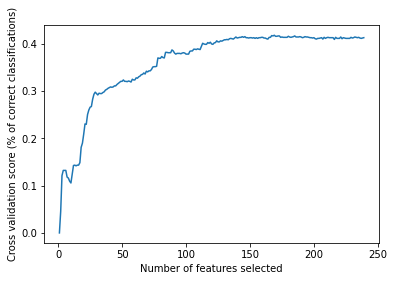

In [18]:
from sklearn.metrics import recall_score

### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv_income = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_income.fit(X_selection_preprocessed_income, y_selection_income)
print("Optimal number of features for Income: %d" % rfecv_income.n_features_)
print("Max Score :", max(rfecv_income.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_income.grid_scores_) + 1), rfecv_income.grid_scores_)
plt.show()

Recursive feature engineering was done with a logistic regression classifier to identify the which features will be useful for the modeling process and to identify which number will be needed to attain this highest accuracy with logistic regression. Above are the results for the first classification task.

Optimal number of features for Graduated: 203
Max Score : 0.48016204472843454


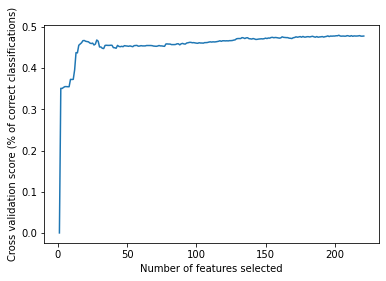

In [19]:
import warnings
warnings.filterwarnings('ignore')

### RFE CV to find best features 
clf = LogisticRegression(n_jobs=-1)
rfecv_grad = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_grad.fit(X_selection_preprocessed_grad, y_selection_grad)
print("Optimal number of features for Graduated: %d" % rfecv_grad.n_features_)
print("Max Score :", max(rfecv_grad.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_grad.grid_scores_) + 1), rfecv_grad.grid_scores_)
plt.show()

This is the feature selection task for the second classification problem for this report.

In [20]:
### Show all selected features
selected_features_income = all_processed_cols_income[rfecv_income.support_]
print(selected_features_income)

['age' 'capital_gains' 'capital_losses' 'stock_dividends' 'num_emp'
 'weeks_worked' 'class_worker_ Local government'
 'class_worker_ Self-employed-incorporated'
 'class_worker_ Self-employed-not incorporated'
 'class_worker_ State government' 'class_worker_ Without pay'
 'det_ind_code_1' 'det_ind_code_2' 'det_ind_code_3' 'det_ind_code_5'
 'det_ind_code_6' 'det_ind_code_8' 'det_ind_code_9' 'det_ind_code_12'
 'det_ind_code_13' 'det_ind_code_14' 'det_ind_code_15' 'det_ind_code_17'
 'det_ind_code_19' 'det_ind_code_20' 'det_ind_code_21' 'det_ind_code_22'
 'det_ind_code_23' 'det_ind_code_24' 'det_ind_code_26' 'det_ind_code_27'
 'det_ind_code_28' 'det_ind_code_29' 'det_ind_code_30' 'det_ind_code_31'
 'det_ind_code_33' 'det_ind_code_34' 'det_ind_code_36' 'det_ind_code_37'
 'det_ind_code_38' 'det_ind_code_39' 'det_ind_code_41' 'det_ind_code_42'
 'det_ind_code_43' 'det_ind_code_44' 'det_ind_code_47' 'det_ind_code_48'
 'det_ind_code_49' 'det_ind_code_50' 'det_ind_code_51' 'det_occ_code_1'
 'det_o

In [21]:
selected_features_grad = all_processed_cols_grad[rfecv_grad.support_]
print(selected_features_grad)

['wage_per_hour' 'capital_gains' 'stock_dividends' 'num_emp'
 'weeks_worked' 'class_worker_ Federal government'
 'class_worker_ Local government' 'class_worker_ Private'
 'class_worker_ Self-employed-not incorporated'
 'class_worker_ Without pay' 'det_ind_code_0' 'det_ind_code_3'
 'det_ind_code_4' 'det_ind_code_5' 'det_ind_code_6' 'det_ind_code_7'
 'det_ind_code_8' 'det_ind_code_9' 'det_ind_code_11' 'det_ind_code_12'
 'det_ind_code_13' 'det_ind_code_14' 'det_ind_code_15' 'det_ind_code_16'
 'det_ind_code_17' 'det_ind_code_18' 'det_ind_code_19' 'det_ind_code_20'
 'det_ind_code_21' 'det_ind_code_22' 'det_ind_code_23' 'det_ind_code_24'
 'det_ind_code_25' 'det_ind_code_26' 'det_ind_code_27' 'det_ind_code_28'
 'det_ind_code_29' 'det_ind_code_30' 'det_ind_code_31' 'det_ind_code_32'
 'det_ind_code_33' 'det_ind_code_34' 'det_ind_code_35' 'det_ind_code_36'
 'det_ind_code_37' 'det_ind_code_38' 'det_ind_code_39' 'det_ind_code_41'
 'det_ind_code_42' 'det_ind_code_43' 'det_ind_code_44' 'det_ind_code

In [22]:
### log 
X_selection_log_income = X_selection_income.copy()
X_selection_log_income['wage_per_hour'] = np.log10(X_selection_log_income['wage_per_hour'] + 1)
X_selection_log_income['capital_gains'] = np.log10(X_selection_log_income['capital_gains'] + 1)
X_selection_log_income['capital_losses'] = np.log10(X_selection_log_income['capital_losses'] + 1)
X_selection_log_income['stock_dividends'] = np.log10(X_selection_log_income['stock_dividends'] + 1)
X_selection_log_preprocessed_income = preprocessor_income.fit_transform(X_selection_log_income)

X_selection_log_grad = X_selection_grad.copy()
X_selection_log_grad['wage_per_hour'] = np.log10(X_selection_log_grad['wage_per_hour'] + 1)
X_selection_log_grad['capital_gains'] = np.log10(X_selection_log_grad['capital_gains'] + 1)
X_selection_log_grad['capital_losses'] = np.log10(X_selection_log_grad['capital_losses'] + 1)
X_selection_log_grad['stock_dividends'] = np.log10(X_selection_log_grad['stock_dividends'] + 1)
X_selection_log_preprocessed_grad = preprocessor_grad.fit_transform(X_selection_log_grad)


Above the numeric features of the dataset are log transformed in an attempt to improve the accuracy of the RFE and to compare with the results already obtained.

Optimal number of features for Income: 236
Max Score : 0.4171655049883832


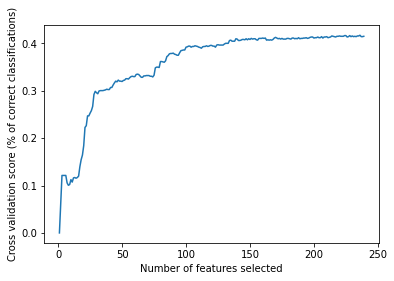

In [23]:
clf = LogisticRegression(n_jobs=-1)
rfecv_log_income = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_log_income.fit(X_selection_log_preprocessed_income, y_selection_income)
print("Optimal number of features for Income: %d" % rfecv_log_income.n_features_)
print("Max Score :", max(rfecv_log_income.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_log_income.grid_scores_) + 1), rfecv_log_income.grid_scores_)
plt.show()

Optimal number of features for Graduated: 219
Max Score : 0.4939148881789137


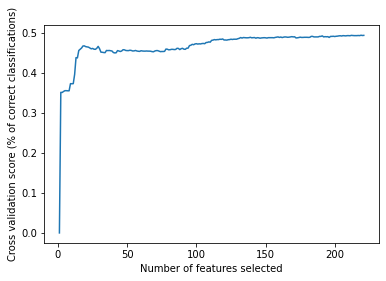

In [24]:
clf = LogisticRegression(n_jobs=-1)
rfecv_log_grad = RFECV(clf, step=1, cv=5, scoring = 'recall')
rfecv_log_grad.fit(X_selection_log_preprocessed_grad, y_selection_grad)
print("Optimal number of features for Graduated: %d" % rfecv_log_grad.n_features_)
print("Max Score :", max(rfecv_log_grad.grid_scores_) )

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (% of correct classifications)")
plt.plot(range(1, len(rfecv_log_grad.grid_scores_) + 1), rfecv_log_grad.grid_scores_)
plt.show()

Another round of RFE was performed on the dataset after log transformation of the numeric variables to see if the recall would improve. There was not a significant increase in recall this will not be done on the final dataset used for modeling.

## Data Preparation Part 2

In [12]:
selection_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20950 entries, 67087 to 17653
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   age               20950 non-null  int64   
 1   class_worker      20950 non-null  category
 2   det_ind_code      20950 non-null  category
 3   det_occ_code      20950 non-null  category
 4   wage_per_hour     20950 non-null  int64   
 5   marital_stat      20950 non-null  category
 6   major_ind_code    20950 non-null  category
 7   major_occ_code    20950 non-null  category
 8   race              20950 non-null  category
 9   hisp_origin       20950 non-null  category
 10  sex               20950 non-null  category
 11  union_member      20950 non-null  category
 12  unemp_reason      20950 non-null  category
 13  full_or_part_emp  20950 non-null  category
 14  capital_gains     20950 non-null  int64   
 15  capital_losses    20950 non-null  int64   
 16  stock_dividends   

In [25]:
### Show all selected features
#index columns of sparse matrix
X_selected_income = X_selection_preprocessed_income.tocsr()[:,rfecv_income.support_] 
selected_features_income = all_processed_cols_income[rfecv_income.support_]

print(selected_features_income)

['age' 'capital_gains' 'capital_losses' 'stock_dividends' 'num_emp'
 'weeks_worked' 'class_worker_ Local government'
 'class_worker_ Self-employed-incorporated'
 'class_worker_ Self-employed-not incorporated'
 'class_worker_ State government' 'class_worker_ Without pay'
 'det_ind_code_1' 'det_ind_code_2' 'det_ind_code_3' 'det_ind_code_5'
 'det_ind_code_6' 'det_ind_code_8' 'det_ind_code_9' 'det_ind_code_12'
 'det_ind_code_13' 'det_ind_code_14' 'det_ind_code_15' 'det_ind_code_17'
 'det_ind_code_19' 'det_ind_code_20' 'det_ind_code_21' 'det_ind_code_22'
 'det_ind_code_23' 'det_ind_code_24' 'det_ind_code_26' 'det_ind_code_27'
 'det_ind_code_28' 'det_ind_code_29' 'det_ind_code_30' 'det_ind_code_31'
 'det_ind_code_33' 'det_ind_code_34' 'det_ind_code_36' 'det_ind_code_37'
 'det_ind_code_38' 'det_ind_code_39' 'det_ind_code_41' 'det_ind_code_42'
 'det_ind_code_43' 'det_ind_code_44' 'det_ind_code_47' 'det_ind_code_48'
 'det_ind_code_49' 'det_ind_code_50' 'det_ind_code_51' 'det_occ_code_1'
 'det_o

In [26]:
X_selected_grad = X_selection_preprocessed_grad.tocsr()[:,rfecv_grad.support_] 
selected_features_grad = all_processed_cols_grad[rfecv_grad.support_]

print(selected_features_grad)

['wage_per_hour' 'capital_gains' 'stock_dividends' 'num_emp'
 'weeks_worked' 'class_worker_ Federal government'
 'class_worker_ Local government' 'class_worker_ Private'
 'class_worker_ Self-employed-not incorporated'
 'class_worker_ Without pay' 'det_ind_code_0' 'det_ind_code_3'
 'det_ind_code_4' 'det_ind_code_5' 'det_ind_code_6' 'det_ind_code_7'
 'det_ind_code_8' 'det_ind_code_9' 'det_ind_code_11' 'det_ind_code_12'
 'det_ind_code_13' 'det_ind_code_14' 'det_ind_code_15' 'det_ind_code_16'
 'det_ind_code_17' 'det_ind_code_18' 'det_ind_code_19' 'det_ind_code_20'
 'det_ind_code_21' 'det_ind_code_22' 'det_ind_code_23' 'det_ind_code_24'
 'det_ind_code_25' 'det_ind_code_26' 'det_ind_code_27' 'det_ind_code_28'
 'det_ind_code_29' 'det_ind_code_30' 'det_ind_code_31' 'det_ind_code_32'
 'det_ind_code_33' 'det_ind_code_34' 'det_ind_code_35' 'det_ind_code_36'
 'det_ind_code_37' 'det_ind_code_38' 'det_ind_code_39' 'det_ind_code_41'
 'det_ind_code_42' 'det_ind_code_43' 'det_ind_code_44' 'det_ind_code

Above are the lists of features that were selected from RFE for each classification task. The first list shows that features that will be used for the income classification task, and the second list shows that features for the graduated classification task.

The final processed dataset is a sparse array representing the variables as numeric after scaling the numeric features and one-hot encoding the categorical attributes.

In [27]:
X_selected_income

<20950x169 sparse matrix of type '<class 'numpy.float64'>'
	with 335636 stored elements in Compressed Sparse Row format>

As stated before, a feature was created for second classification task being the graduation status. If a person has attained a higher education degree, they will be considered to have graduated. Below is the description of the dataset that will be used for the newly created `graduated` feature.

In [28]:
X_selected_grad

<20950x203 sparse matrix of type '<class 'numpy.float64'>'
	with 484630 stored elements in Compressed Sparse Row format>

## Modeling and Evaluation

### Model and Evaluation 1

In our analysis we decided to use the recall as the appropriate measure for interpreting the power of our models. Since our project mainly deals with a binary classification, we found that the recall is the best measure for how well our models are correctly classifying the true positives. In our scenario, we are trying to predict whether the income is over or under 50k and graduation (whether the individual graduated from high school or college). In addition, the classes in our data is not properly balanced. Meaning there is more of one type of class than there is the other. The accuracy measure would have given us a very biased score.

Recall seems to be the perfect metric because it tells us the proportion of classifications that have been identified correctly by the algorithm. In essence, we want it to tell us how well it correctly identifies people making more than 50k and whether or not people are graduating. In the models that will follow, the recall scores can be observed. 

### Model and Evaluation 2

For the models we have created, we have been using stratified 10-fold cross validation. This method is being applied when we are running the GridSearchCV function which also gives us the best parameters to use for that chosen model. Additionally, GridSearch function did not have a random seed parameter. We used the following function to set the seed to make sure the splits are even: np.random.seed. 

We went with the stratified method since this a binary classification problem and we want balanced classes. K-fold cross validation because it allows us to use all the data in the test at some point, which gives us a more robust test score. We went with 10 k-fold validation because it balances runtime and splits effectively. Especially, since we are working with a large number of values, the balance is important which stratified helps us achieve. This is so that the data is arranged in a way that every fold comprises of half the instances. This will also prove useful because we want to see which one our five models will do well utilizing this method.

### Model and Evaluation 3

In [29]:
#### Decision Tree for income
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    'class_weight': ['balanced', None],
}

CV_dt_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_dt_income.fit(X_selected_income, y_selection_income)
    
print('Best Score: {s}'.format(s=CV_dt_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_dt_income.best_params_))  

Best Score: 0.9230827886710239
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


In [30]:
#### Decision Tree for graduation
classifier = DecisionTreeClassifier()
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth' : [2, None],
    'min_samples_split' : [2, 3, 4],
    'min_samples_leaf' : [1,2,3],
    'class_weight': ['balanced', None],

}

CV_dt_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_dt_grad.fit(X_selected_grad, y_selection_grad)
    
print('Best Score: {s}'.format(s=CV_dt_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_dt_grad.best_params_))  

Best Score: 0.9574537150815106
Best Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}


The two model seen above are the Decision Tree models ran with `GridSearchCV` to find the optimal parameters that we can tune to predict income and graduated class. As mentioned in prior segments, recall is the metric of choice. The recall score for the models is at 92% and 95% respectively. It helps us correctly classify the true positives, in which case is income above 50k and whether the individual graduated.

Both models recall scores were within close proximity with each other. The decision tree model for predicting graduation is a little bit better. However, the differences lie at the parameters chosen via GridSearch. The `criterion` for income, the best parameter chosen was "entropy" compared to "gini" for the graduated class. The other parameters `splitter`, `max_depth`, `min_samples_split`, `min_sample_leaf`, and `class_weight` did not change.

In [31]:
#### Logistic Regression for income
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    #'penalty' : ['l1', 'l2',],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter': [99999],
}

CV_lr_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_lr_income.fit(X_selected_income, y_selection_income)
    
print('Best Score: {s}'.format(s=CV_lr_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_lr_income.best_params_)) 


Best Score: 0.8779411764705882
Best Parameters: {'class_weight': 'balanced', 'max_iter': 99999, 'solver': 'liblinear'}


In [32]:
#### Logistic Regression for graduation
classifier = LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    #'penalty' : ['l1', 'l2',],
    'solver' : ['lbfgs', 'liblinear'],
    'max_iter': [99999],
}

CV_lr_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_lr_grad.fit(X_selected_grad, y_selection_grad)
    
print('Best Score: {s}'.format(s=CV_lr_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_lr_grad.best_params_)) 

Best Score: 0.7741490538215777
Best Parameters: {'class_weight': 'balanced', 'max_iter': 99999, 'solver': 'liblinear'}


The logistic regression model shown above was ran via `GridSearch` and built the model with the best parameters. 

The logistic regression is a form of linear regression that allows us to classify binomial data. In logistic regression, the log of the odds that the response (income > $50k) is has an affirmative value equals a weighted sum of the explanatory features and an intercept term. Our goal is to find the optimal weights and intercept.

The parameters that we used to try to optimize the logistic regression classifier are the class weight, solver, and max iteration. The `class_weight` means the classifier will try to give equal weight to predicting income > $50k vs < \\$50k, we tried with and without balanced class weight. The `solver` parameter is the specific algorithm used to find the optimal coefficients (feature weights). We tried the default 'lbfgs' and 'liblinear' which is recommended in the documentation for high dimensional data. We also have many features so the iteration takes much more time. The default value for this parameter is 100. Regularization is a penalty term that downweight models with large coefficients in an attempt to control overfitting.

The recall score for the income class and graduation is at 87% and 77\% respectively. The chosen parameters are the same across both models.

In [34]:
#### KNN for income
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [5, 10,100,200],
    'weights': ['uniform', 'distance'],
}
CV_knn_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_knn_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_knn_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_knn_income.best_params_))


Best Score: 0.38609477124183
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}


In [35]:
#### KNN for graduation
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier()
param_grid = { 
    'n_neighbors': [5, 10,100,200],
    'weights': ['uniform', 'distance']
}
CV_knn_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_knn_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_knn_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_knn_grad.best_params_))

Best Score: 0.4747327353158024
Best Parameters: {'n_neighbors': 5, 'weights': 'distance'}


Similar to Decision Tree and Logistics regression, we ran `KNN` with `GridSearchCV` to find optimal parameters. For KNN, in our model we have tried 2 parameters, n_neighbors and `weights`. By default, the default value of weights parameter is `uniform`. In our model, we tried "uniform" and "distance" and it picked "distance" as the best parameter for both income and graduation classification.For `n_neighbors`, we tried 5, 10,100, 200 values based on our dataset. And it considered 5 as the best performing `n_neighbors` for both income and graduation classification.We got recall score of 47% and 38% for graduate and income classification respectively.

In [36]:
#### AdaBoost for income
import warnings
warnings.filterwarnings('ignore')
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
param_grid = { 
    'n_estimators': [50, 100, 200],
    'learning_rate': [.1, .5, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

CV_ada_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_ada_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_ada_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_ada_income.best_params_))

Best Score: 0.4540631808278867
Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 200}


In [37]:
#### AdaBoost for graduation
import warnings
warnings.filterwarnings('ignore')
classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
param_grid = { 
    'n_estimators': [50, 100, 200],
    'learning_rate': [.1, .5, 1],
    'algorithm': ['SAMME.R', 'SAMME']
}

CV_ada_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_ada_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_ada_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_ada_grad.best_params_))


Best Score: 0.49584050135168345
Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 100}


In this section AdaBoost is used for classification and a recall scores of 45% and 50% are attained for income and graduated, respectively. AdaBoost is an ensemble technique that iteratively runs weak learners, reweighing sample that are hard to classify so that the algorithm iteratively improves on the hardest points to classify. Here we are using decision stumps (1 level decision trees) as our weak learner. 

The parameters we tuned for AdaBoost are the `learning_rate`, maximum number of estimators (`n_estimators`), and the `algorithm` used for boosting. The learning rate represents how much each iteration changes the overall model and the estimators controls the iterations of boosting.

In [38]:
#### Gradient Boosting for income
from sklearn.ensemble import GradientBoostingClassifier

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate' : [0.001, 0.1, 0.5, 1],
    'max_depth': [1,2,3],
}

classifier = GradientBoostingClassifier(random_state=1)


CV_gbc_income = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_gbc_income.fit(X_selected_income, y_selection_income)

print('Best Score: {s}'.format(s=CV_gbc_income.best_score_))
print('Best Parameters: {p}'.format(p=CV_gbc_income.best_params_))

Best Score: 0.4703921568627451
Best Parameters: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 200}


In [39]:
#### Gradient Boosting for graduation
from sklearn.ensemble import GradientBoostingClassifier

param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'learning_rate' : [0.001, 0.1, 0.5, 1],
    'max_depth': [1,2,3],
}

classifier = GradientBoostingClassifier(random_state=1)


CV_gbc_grad = GridSearchCV(classifier, param_grid, scoring='recall', cv=10, n_jobs= -1)
CV_gbc_grad.fit(X_selected_grad, y_selection_grad)

print('Best Score: {s}'.format(s=CV_gbc_grad.best_score_))
print('Best Parameters: {p}'.format(p=CV_gbc_grad.best_params_))

Best Score: 0.5028733513557795
Best Parameters: {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 200}


Above are the gradient boosting models for each classification task. They have a recall score of 47% and 50% for income and graduation respectively. This is an ensemble method that has a similar methodology to Adaboost classification. Gradient boosting takes an ensemble of weak learning decision trees to build the model in an additive forward stage-wise method. It generalizes the results to allow optimization of an arbitrary differentiable loss function used in calculations. The number of decision tree stumps, or boosting stages, is controlled by the `n_estimators` parameters. The `learning_rate` parameter controls the contribution of each weak learning decision tree stump. The `max_depth` parameter controls the depth of each of the decision tree used during the boosting stages. The best parameter for each of these classification tasks was tuned with a seeded `GridSearchCV` function to find the ideal parameters by recall score.

### Model and Evaluation 4

In [40]:
import yellowbrick 
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ConfusionMatrix


from yellowbrick.classifier import ROCAUC
#%matplotlib inline

    
def plot_confusionmatrix(model, model_name, X_train, y_train, X_test, y_test):
    plt.figure()
    plt.title("Confusion Matrix {m}".format(m=model_name), fontsize=18)
    plt.xlabel("Predicted Class", fontsize=16)
    plt.ylabel("True Class", fontsize=15)
    cm = ConfusionMatrix(model, classes=[0,1], size=(250,250), fontsize=15, cmap='GnBu')
    cm.fit(X_train, y_train)
    cm.score(X_test, y_test)
    plt.show()
    
def plot_rocauc_chart(model, model_name, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(10,4))
    plt.title("ROC Curve and AUC {m}".format(m=model_name), fontsize=18)
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)
    visualizer = ROCAUC(model, classes=[0,1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    plt.legend()
    plt.show()

def plot_all_rocs(models, model_names, X_train, y_train, X_test, y_test):
    fig, axes = plt.subplots(1,1)
    for i, model in enumerate(models):
        visualizer = ROCAUC(model, classes=[0,1], ax=axes, binary=True)
        visualizer.fit(X_train, y_train)
        visualizer.score(X_test, y_test)
        visualizer.ax.get_lines()[i*2].set_label(model_names[i])
        visualizer.finalize()

    plt.show() 
    
def plot_model_score_time(models):
    scores = []
    times = []
    models_str = []
    for model in models:
        mean_model_times = model.cv_results_['mean_fit_time'].sum() + model.cv_results_['mean_fit_time'].sum()
        models_str.append(str(model.best_estimator_))
        times.append(mean_model_times)
        scores.append(model.best_score_)

    performance = pd.DataFrame(data={'score': scores, 'time': times, 'model': models_str})

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(
        performance['model'], 
        performance['time'], 
        alpha=0.8,

    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=20, horizontalalignment='right')
    ax2 = ax.twinx() # dual axis graph
    # line graph of % target in category
    ax2 = sns.pointplot(
        x=performance['model'], 
        y=performance['score'], 
        color='black', 
        legend=False
    )
    plt.show()

In [41]:
X_grad_train, X_grad_test, y_grad_train, y_grad_test = train_test_split(X_selected_grad, y_selection_grad, test_size=0.2)
X_income_train, X_income_test, y_income_train, y_income_test = train_test_split(X_selected_income, y_selection_income, test_size=0.2)

In [53]:
models_grad = [
    KNeighborsClassifier(weights='distance'),
    DecisionTreeClassifier(max_depth=2, class_weight='balanced'),
    GradientBoostingClassifier(learning_rate=1, n_estimators=200),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=1, n_estimators=100),
    LogisticRegression(class_weight='balanced', max_iter=99999, solver='liblinear'),
]
models_income = [
    KNeighborsClassifier(weights='distance'),
    DecisionTreeClassifier(max_depth=2, class_weight='balanced', criterion='entropy'),
    GradientBoostingClassifier(learning_rate=.5, n_estimators=200),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), learning_rate=1, n_estimators=200),
    LogisticRegression(class_weight='balanced', max_iter=99999, solver='liblinear'),
]
model_names = ['KNN', 'Decision Tree', 'GBC', 'AdaBoost', 'Logistic Regression']

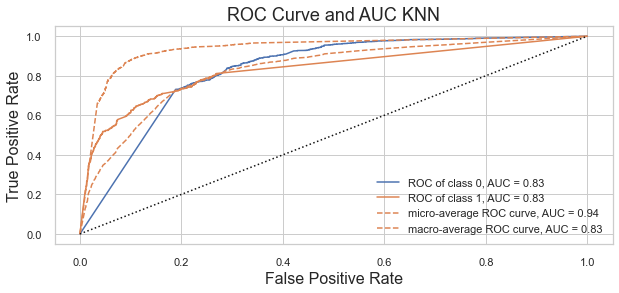

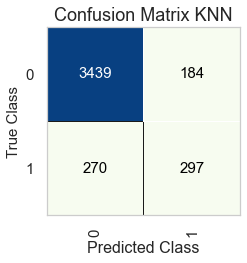

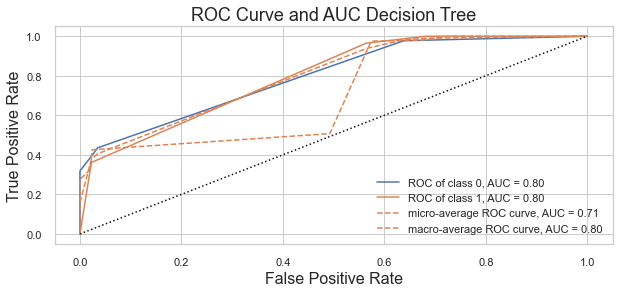

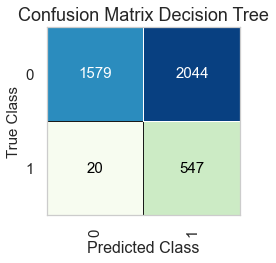

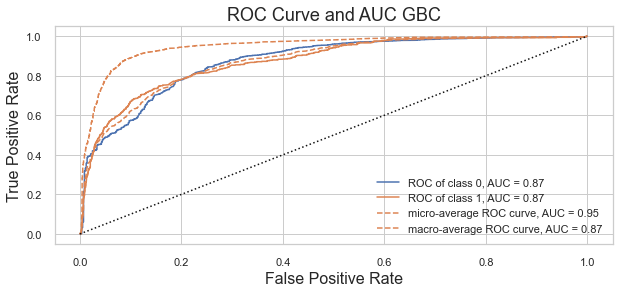

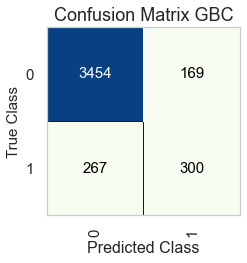

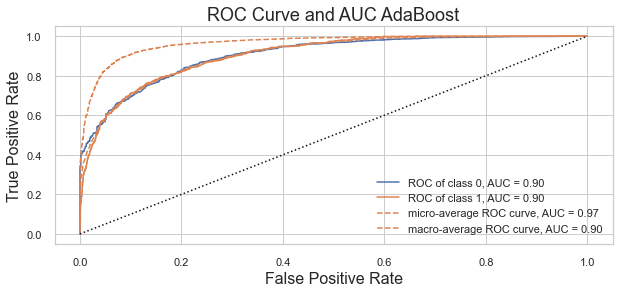

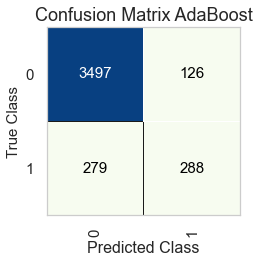

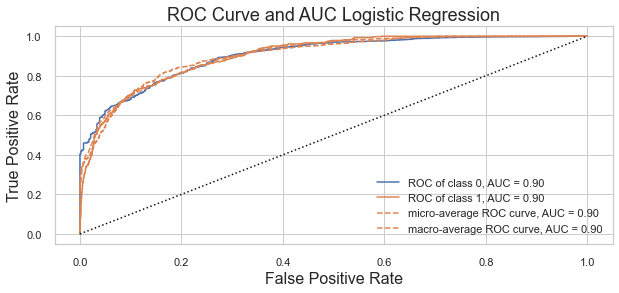

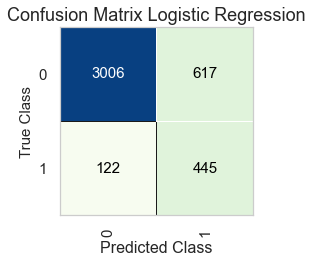

In [54]:
for i, model in enumerate(models_grad): 
    plot_rocauc_chart(model, model_names[i], X_grad_train, y_grad_train, X_grad_test, y_grad_test)
    plot_confusionmatrix(model, model_names[i], X_grad_train, y_grad_train, X_grad_test, y_grad_test)

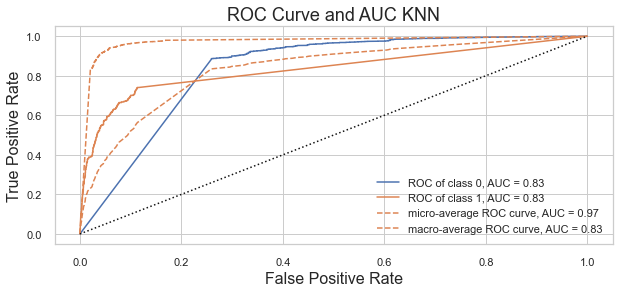

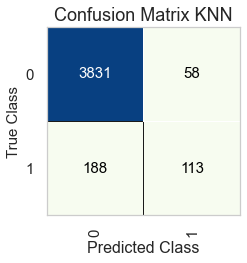

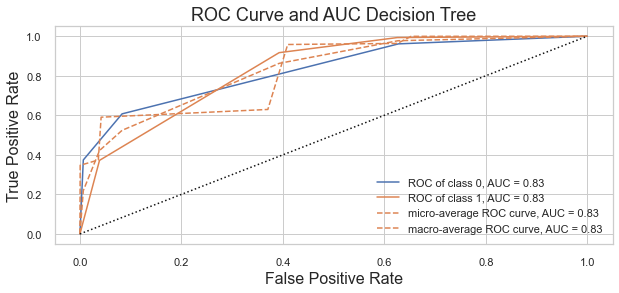

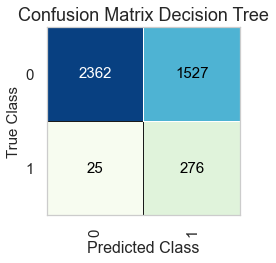

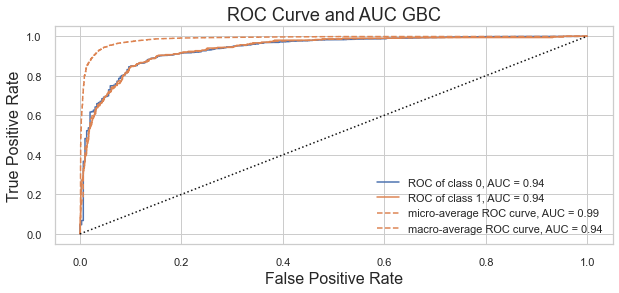

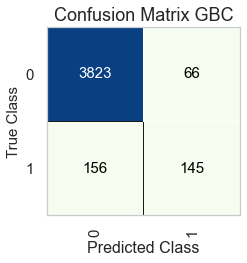

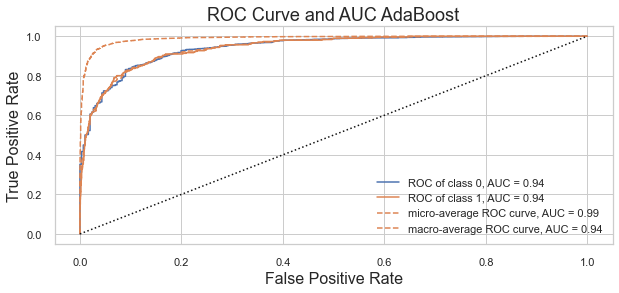

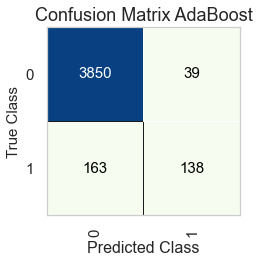

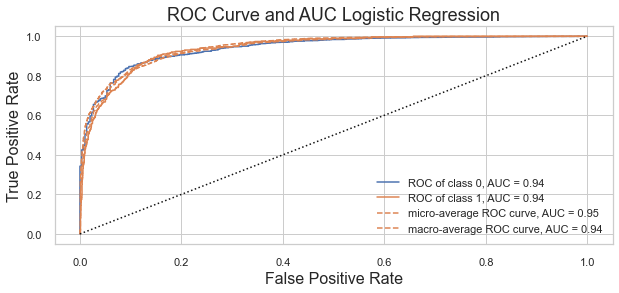

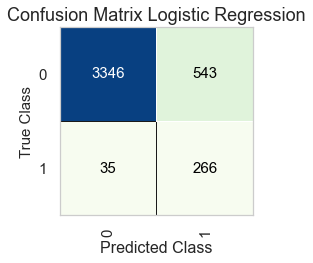

In [55]:
for i, model in enumerate(models_income): 
    plot_rocauc_chart(model, model_names[i], X_income_train, y_income_train, X_income_test, y_income_test)
    plot_confusionmatrix(model, model_names[i], X_income_train, y_income_train, X_income_test, y_income_test)

The above visualizations show the ROC curves and also the confusion matrix for each model. The confusion matrix breaks down the classes and shows us the true positives, false positives, true negatives, and false negatives. In our scenario, we were only looking at the recall score because we are more interested in the true positives, calculated by $Recall = \frac{TP}{TP + FN}$. 

One thing that was considered was when looking at the recall score is that the precision score is usually the opposite. 

$Precision = \frac{TP}{TP + FP}$ 

Precision score for the above models is as follows:

Income Class - All numbers rounded to whole number

- KNN --> 66%
- Decision Tree --> 15%
- Gradient Boost --> 69%
- Adaboost --> 78%
- Logistic Regression --> 33%

Graduate Class - All numbers rounded to whole number

- KNN --> 62%
- Decision Tree --> 21%
- Gradient Boost --> 64%
- Adaboost --> 69%
- Logistic Regression --> 42%

The ROC curves above also add additional weight to validate the balance between the true positives and the false positives. This is indicates that the true positive identification more accurate than guessing. 

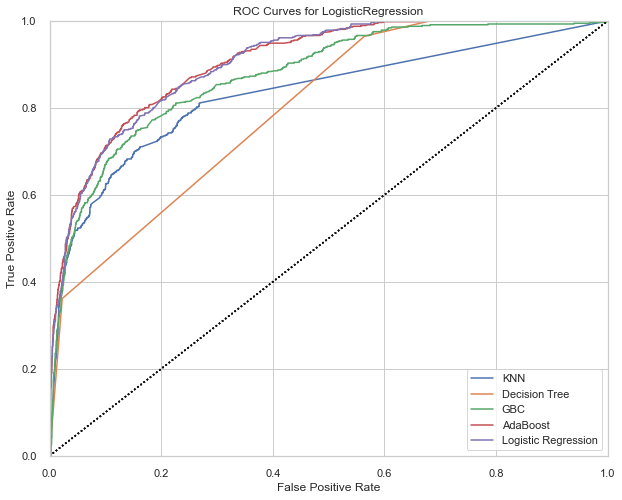

In [56]:
plot_all_rocs(models_grad, model_names, X_grad_train, y_grad_train, X_grad_test, y_grad_test)

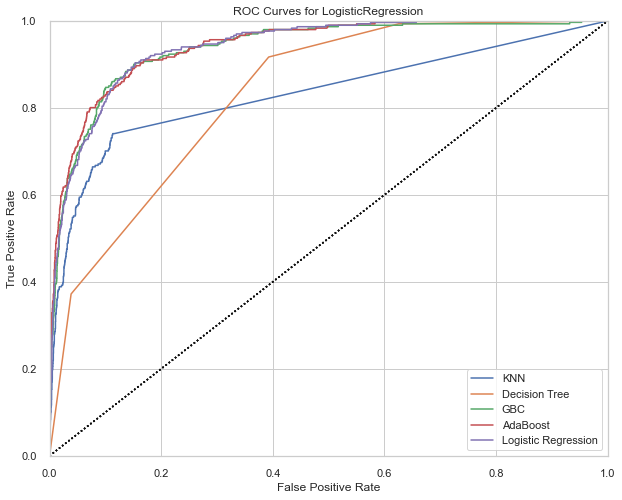

In [57]:
plot_all_rocs(models_income, model_names, X_income_train, y_income_train, X_income_test, y_income_test)

The above two ROC curves shows us the tradeoff between the false positive and the true positive rate for all the models. As seen, it seems that logistic regression curves is roughly equivalent to the adaboost model, however the recall performance for the logistic regression model is better because the classes are more balanced. 

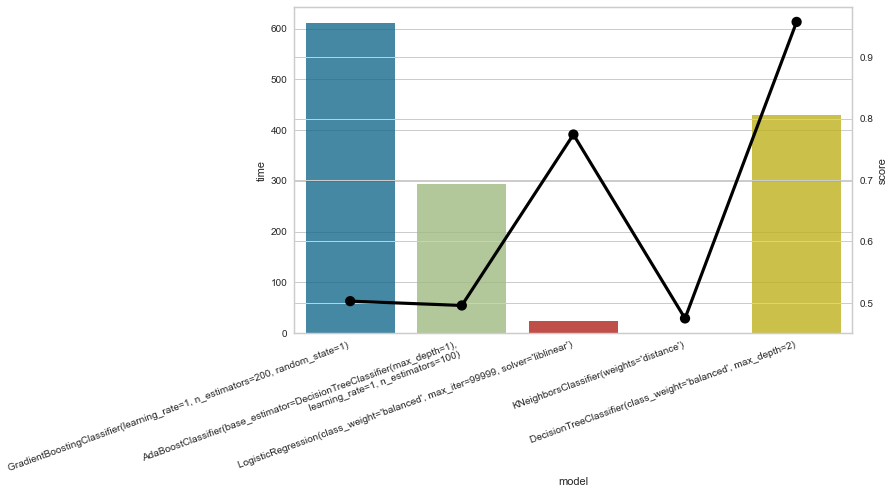

In [47]:
cv_models_grad = [CV_gbc_grad, CV_ada_grad, CV_lr_grad, CV_knn_grad, CV_dt_grad]
plot_model_score_time(cv_models_grad)

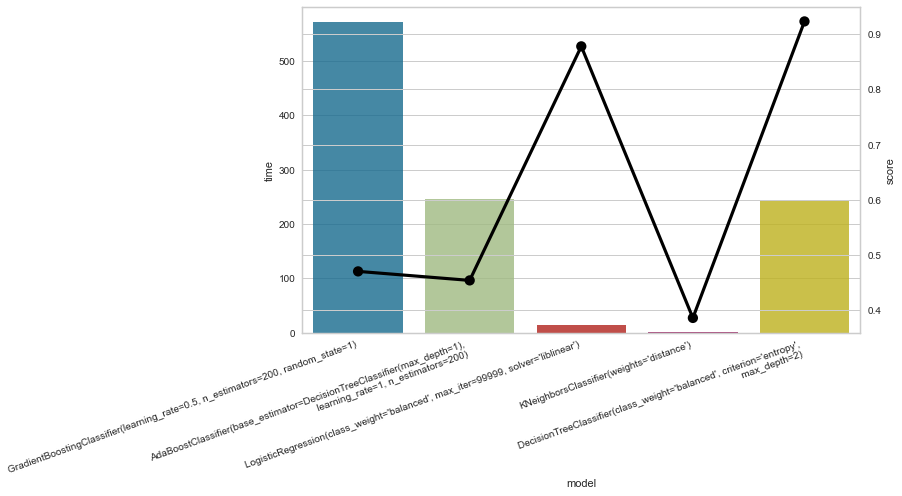

In [48]:
cv_models_income = [CV_gbc_income, CV_ada_income,CV_lr_income, CV_knn_income, CV_dt_income]
plot_model_score_time(cv_models_income)

The bar charts above depict relative time it takes to run cross validation to find the best parameters to use in these models compared to the recall scores. This gives a practical perspective of the tradeoff between performance and run time for all the models. 

On the models that were used to predict graduation and income, KNN had the fastest runtime. This contributes to the advantage and disadvantages of our different models as explained in the next section.

### Model and Evaluation 5

In [58]:
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=CV_dt_grad , estimator2=CV_lr_grad , X=X_selected_grad, y=y_selection_grad , random_seed=1)
print('Paired t-test P-value for accuracy difference:', p)

Paired t-test P-value for accuracy difference: 1.6090842254315348e-09


In [59]:
t, p = paired_ttest_5x2cv(estimator1=CV_dt_income , estimator2=CV_lr_income , X=X_selected_income, y=y_selection_income , random_seed=1)
print('Paired t-test P-value for accuracy difference:', p)

Paired t-test P-value for accuracy difference: 0.42950393869785775


The different models used in this analysis have various advantages and disadvantages. The simplest models to interpret are the logistic regression model and decision trees. With logistic regression, the coefficients map to increased log likelihood of a positive classification. This make it easy to audit which scores contribute to the model overall and easy to calculate how an individual would score manually. With decision trees, a human is similarly able to understand the model and how individuals would be categorized by reading the tree.

KNNs are difficult to interpret because they are a graphical technique. The ensemble techniques AdaBoost with decision stumps and Gradient Boosted Classification are also difficult to interpret because they create many models. The models produced can be averaged in different ways to find relative feature importance for some visibility into how different attributes contribute to the model.

In terms of run time, AdaBoost and Gradient Boosting took by far the longest. Decision trees took almost as much time as the ensemble methods and Logistic regression and KNN were fastest with KNN being by far the fastest. These times are an important consideration when trying to run the full dataset.

From a scoring perspective Logistic regression and decision trees were by far the best. Given how they internally handled class weighting, they were able to outperform the other models with the same level of preprocessing. AdaBoost and GBC performed similarly and KNNs had the worst recall. All of these finding were relatively consistent between the two classification tasks.

A paired t-test was run for both classification tasks to compare Logistic regression against decison trees (the best performing models). For income the descion tree performed significantly better with a probobility of 1.61e-09. For graduated there was not a significant difference as the p-value was 0.43.

### Model and Evaluation 6

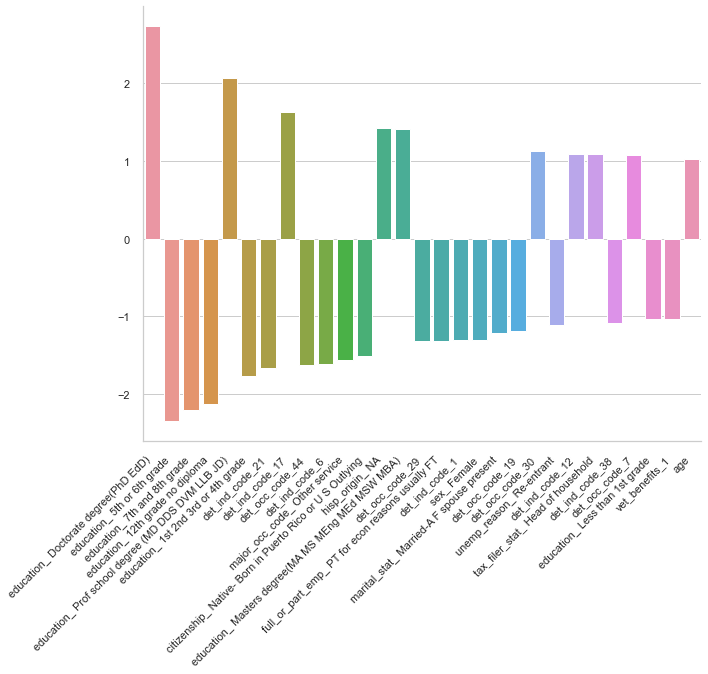

In [51]:
best_lr_coefs_income = CV_lr_income.best_estimator_.coef_
coef_scores_income = [coef_score for coef_score in zip(selected_features_income,best_lr_coefs_income[0])]
coef_scores_income.sort(key=lambda tup: abs(tup[1]), reverse=True)

features_income = [p[0] for p in coef_scores_income if abs(p[1]) > 1]
scores_income = [p[1] for p in coef_scores_income if abs(p[1]) > 1]

sns.set(rc={'figure.figsize':(10, 8)})
# sns.set_context("paper", font_scale=0.9)
sns.set_style("whitegrid")

ax = sns.barplot(x=features_income, y=scores_income)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine()


To evaluate which attributes were most meaningful in classification tasks, we will look at the coefficients of the logistic regression model which was a well performing model and the easiest to interpret.

For classifying income, education is a very important feature. A doctorate degree is the positive indicator most strongly associate with income over \\$50k and professional degrees and masters degrees are also highly positively predictive. The strongest negative predictors of income over \\$50k were education of 5th or 6th grade, education of 7th or 8th grade, and education of 12th grade with no diploma. It makes sense from a job perspective that the job market values those with more education and people with higher education earn more and those that did not finish basic education would earn less.

Two other attributes that are important are the det_ind_code and det_occ_code. These attributes represent the industry and the occupation of the person. Det_ind_code 21 is a highly negative indicator of income over \\$50k while code 17 is a highly positive indicator. Det_occ_code s a highly negative indicator of income over \\$50k. We don’t know what these jobs or industries represent, but it is understood that different industries pay different wages and that wages also vary by occupation. 

One concerning attribute is that being female is a negative indicator of income over \\$50k. Unfortunately, the wage disparity between men and women is well documented.

Another feature that is prominent is when a worker is part-time for economic reason but usually full time. This might be an indicator of people who need any income they can get, and it makes sense that these people would have lower income.

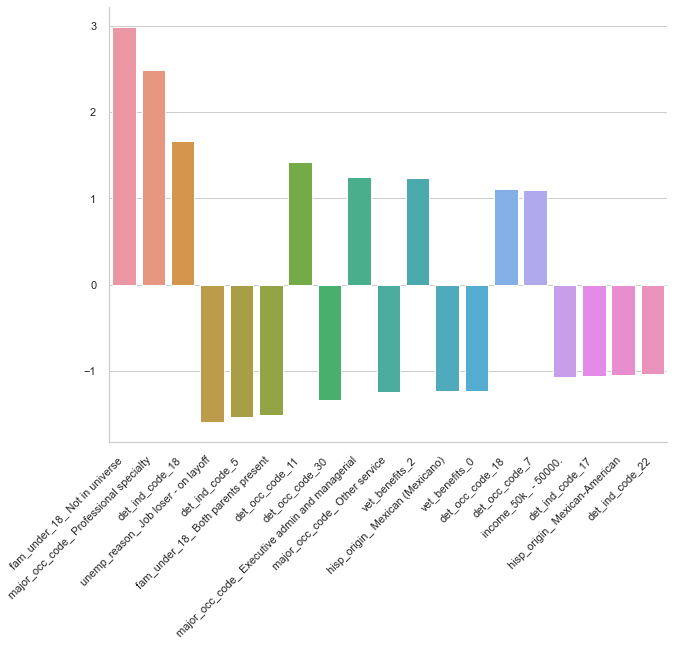

In [52]:
best_lr_coefs_grad = CV_lr_grad.best_estimator_.coef_
coef_scores_grad = [coef_score for coef_score in zip(selected_features_grad,best_lr_coefs_grad[0])]
coef_scores_grad.sort(key=lambda tup: abs(tup[1]), reverse=True)

features_grad = [p[0] for p in coef_scores_grad if abs(p[1]) > 1]
scores_grad = [p[1] for p in coef_scores_grad if abs(p[1]) > 1]

sns.set(rc={'figure.figsize':(10, 8)})
# sns.set_context("paper", font_scale=0.9)
sns.set_style("whitegrid")

ax = sns.barplot(x=features_grad, y=scores_grad)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
sns.despine()



For classification of graduated, by far the most predictive feature is if the family_under_18 attribute is ’Not in universe’. This mean that the person in not a child since all the other values of that field are for children. This is expected be since most people attain a degree as adults.

Another highly positive indicator is if the person works in professional specialty occupations. Generally professional specialty jobs are more technical and often require an undergraduate degree at minimum. Those with the occupation code Executive admin and managerial were also more likely to have graduated as well, which is expected given the responsibility in those positions.

Other industry and occupation codes are highly predictive as well: industry code 18 is a positive indicator of having graduated, as well as occupation code 11. Industry code 5 and occupation code 30 are negative indicators of having graduated. Given the different requirements in different occupations and industries, these differences in education distributions are expected.

One attribute that should be noted is vet_benefits. Those with a value of 0 were less likely to have a degree and those with a 2 value were more likely to have graduated. This could be a result of GI benefits which subsidizes the education of military members.

### Deployment

The below companies and parties might want to use our model to predict the following:

To predict income:
-	IRS
-	Marketing agencies
-	Real Estate

To predict graduation:
-	Job agency
-	Political parties
-	Graduate school recruiting

One thing that interested parties can find useful about our model is that it can run quickly and effectively with much higher recall scores compared to guessing. In terms of the value, it is really up to the company on how they want to apply this model. Since the recall score is the metric of choice, this can be specifically useful for the interested parties to get the true positives. The model can be deployed in the cloud environment for high availability and scaling. The pipeline was designed so it can process the unseen data which than can be used in the model. This is so that anyone can easily utilize the model to process the unseen data. Other data that can be collected is real estate information (rent or own, type of home, price of home, etc…) and whether this individual will want to pursue a higher education. This type of model can be updated monthly based on additional data that is collected.  However, updating more than a month is not necessary because these types of attributes are not prone to frequent change.

### Exceptional Work

In terms of our exceptional work we performed different types of techniques to get the optimal results. As seen in the work above:

- Cross Validated RFE (Data Preparation Part 1 and 2)
- GridSearchCV
- 5 different models (Logistic Regression, KNN, Decision Trees, Adaboost, Gradient Boosting)

Cross validated recursive feature engineering gave us the best features to utilize in our model.

Gridsearch performed stratified kfold cross validation that resulted in finding the best parameters and the best recall score for our five models. Additionally, the parameters that were chosen as part of the grid search assisted with our visuals (ROC Curves, Confusion Matrix).

We also added two additional models, such as Adaboost and Gradient boosting (fourth and fifth models in "Model and Evaulation 3") which were not explicitly covered in class.

## References

https://medium.com/@xzz201920/stratifiedkfold-v-s-kfold-v-s-stratifiedshufflesplit-ffcae5bfdf

https://www.analyticsvidhya.com/blog/2020/09/precision-recall-machine-learning/

https://medium.com/@shrutisaxena0617/precision-vs-recall-386cf9f89488

https://medium.com/swlh/explaining-accuracy-precision-recall-and-f1-score-f29d370caaa8